final project
===
due: June 30 2022

authors: pegler, prüwasser, scheftner

In [105]:
import pandas as pd
import matplotlib.pyplot as plt 
from glob import glob


files = glob("data/final_data/*.csv")

dfs = []

for file in files:

    dfs.append(pd.read_csv(file, sep=";", index_col=0))

In [47]:
files[13]

'data/final_data/auc_ec_eo_with_gamma.csv'

In [55]:
dfs[13]

,Factor,Power,Time,ROI,Frequency,Eyes
id,,,,,,
1,GAMMA_aucp_PRE_EC_midline,0.003900,Pre,Midline,Gamma,EC
2,GAMMA_aucp_PRE_EC_midline,0.004960,Pre,Midline,Gamma,EC
3,GAMMA_aucp_PRE_EC_midline,0.006120,Pre,Midline,Gamma,EC
4,GAMMA_aucp_PRE_EC_midline,0.011220,Pre,Midline,Gamma,EC
5,GAMMA_aucp_PRE_EC_midline,0.023780,Pre,Midline,Gamma,EC
...,...,...,...,...,...,...
10,DELTA_aucp_POST_EO_parietotemporalPURE,0.225500,Post,Parietotemporal,Delta,EO
11,DELTA_aucp_POST_EO_parietotemporalPURE,0.152475,Post,Parietotemporal,Delta,EO
12,DELTA_aucp_POST_EO_parietotemporalPURE,0.173900,Post,Parietotemporal,Delta,EO


In [65]:
df_grp = dfs[13].groupby(["Time", "Frequency", "ROI"]).mean().reset_index()
df_grp

,Time,Frequency,ROI,Power
0,Post,Alpha,Midline,0.234329
1,Post,Alpha,Parietotemporal,0.261767
2,Post,Delta,Midline,0.201376
3,Post,Delta,Parietotemporal,0.164670
4,Post,Gamma,Midline,0.015928
5,Post,Gamma,Parietotemporal,0.020814
6,Post,Theta,Midline,0.187758
7,Post,Theta,Parietotemporal,0.159707
8,Pre,Alpha,Midline,0.212806
9,Pre,Alpha,Parietotemporal,0.253216


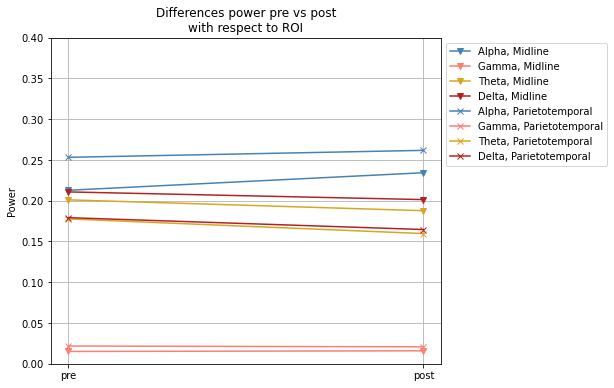

In [124]:
plt.figure(figsize=(7, 6))

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Alpha") & (df_grp.ROI=="Midline"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Alpha") & (df_grp.ROI=="Midline"), "Power"]
                          ], label="Alpha, Midline", color="steelblue", marker="v")

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Gamma") & (df_grp.ROI=="Midline"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Gamma") & (df_grp.ROI=="Midline"), "Power"]
                          ], label="Gamma, Midline", color="salmon", marker="v")

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Theta") & (df_grp.ROI=="Midline"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Theta") & (df_grp.ROI=="Midline"), "Power"]
                          ], label="Theta, Midline", color="goldenrod", marker="v")

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Delta") & (df_grp.ROI=="Midline"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Delta") & (df_grp.ROI=="Midline"), "Power"]
                          ], label="Delta, Midline", color="firebrick", marker="v")

#

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Alpha") & (df_grp.ROI=="Parietotemporal"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Alpha") & (df_grp.ROI=="Parietotemporal"), "Power"]
                          ], label="Alpha, Parietotemporal", color="steelblue", marker="x")

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Gamma") & (df_grp.ROI=="Parietotemporal"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Gamma") & (df_grp.ROI=="Parietotemporal"), "Power"]
                          ], label="Gamma, Parietotemporal", color="salmon", marker="x")

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Theta") & (df_grp.ROI=="Parietotemporal"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Theta") & (df_grp.ROI=="Parietotemporal"), "Power"]
                          ], label="Theta, Parietotemporal", color="goldenrod", marker="x")

plt.plot(["pre" ,"post"], [df_grp.loc[(df_grp.Time=="Pre") & (df_grp.Frequency=="Delta") & (df_grp.ROI=="Parietotemporal"), "Power"],
                           df_grp.loc[(df_grp.Time=="Post") & (df_grp.Frequency=="Delta") & (df_grp.ROI=="Parietotemporal"), "Power"]
                          ], label="Delta, Parietotemporal", color="firebrick", marker="x")

plt.ylim(0, 0.4)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Differences power pre vs post\nwith respect to ROI")
plt.ylabel("Power")
plt.grid()

In [106]:
df_grp_e = dfs[13].groupby(["Time", "Frequency", "Eyes"]).mean().reset_index()
df_grp_e

,Time,Frequency,Eyes,Power
0,Post,Alpha,EC,0.305729
1,Post,Alpha,EO,0.190367
2,Post,Delta,EC,0.168508
3,Post,Delta,EO,0.197538
4,Post,Gamma,EC,0.015249
5,Post,Gamma,EO,0.021493
6,Post,Theta,EC,0.165505
7,Post,Theta,EO,0.181960
8,Pre,Alpha,EC,0.280893
9,Pre,Alpha,EO,0.185128


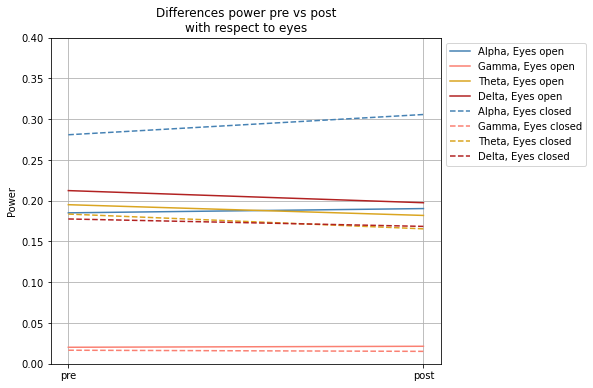

In [116]:
plt.figure(figsize=(7, 6))

plt.plot(["pre" ,"post"], [df_grp_e.loc[(df_grp_e.Time=="Pre") & (df_grp_e.Frequency=="Alpha") & (df_grp_e.Eyes=="EO"), "Power"],
                           df_grp_e.loc[(df_grp_e.Time=="Post") & (df_grp_e.Frequency=="Alpha") & (df_grp_e.Eyes=="EO"), "Power"]
                          ], label="Alpha, Eyes open", color="steelblue")

plt.plot(["pre" ,"post"], [df_grp_e.loc[(df_grp_e.Time=="Pre") & (df_grp_e.Frequency=="Gamma") & (df_grp_e.Eyes=="EO"), "Power"],
                           df_grp_e.loc[(df_grp_e.Time=="Post") & (df_grp_e.Frequency=="Gamma") & (df_grp_e.Eyes=="EO"), "Power"]
                          ], label="Gamma, Eyes open", color="salmon")

plt.plot(["pre" ,"post"], [df_grp_e.loc[(df_grp_e.Time=="Pre") & (df_grp_e.Frequency=="Theta") & (df_grp_e.Eyes=="EO"), "Power"],
                           df_grp_e.loc[(df_grp_e.Time=="Post") & (df_grp_e.Frequency=="Theta") & (df_grp_e.Eyes=="EO"), "Power"]
                          ], label="Theta, Eyes open", color="goldenrod")

plt.plot(["pre" ,"post"], [df_grp_e.loc[(df_grp_e.Time=="Pre") & (df_grp_e.Frequency=="Delta") & (df_grp_e.Eyes=="EO"), "Power"],
                           df_grp_e.loc[(df_grp_e.Time=="Post") & (df_grp_e.Frequency=="Delta") & (df_grp_e.Eyes=="EO"), "Power"]
                          ], label="Delta, Eyes open", color="firebrick")

#

plt.plot(["pre" ,"post"], [df_grp_e.loc[(df_grp_e.Time=="Pre") & (df_grp_e.Frequency=="Alpha") & (df_grp_e.Eyes=="EC"), "Power"],
                           df_grp_e.loc[(df_grp_e.Time=="Post") & (df_grp_e.Frequency=="Alpha") & (df_grp_e.Eyes=="EC"), "Power"]
                          ], label="Alpha, Eyes closed", linestyle="--", color="steelblue")

plt.plot(["pre" ,"post"], [df_grp_e.loc[(df_grp_e.Time=="Pre") & (df_grp_e.Frequency=="Gamma") & (df_grp_e.Eyes=="EC"), "Power"],
                           df_grp_e.loc[(df_grp_e.Time=="Post") & (df_grp_e.Frequency=="Gamma") & (df_grp_e.Eyes=="EC"), "Power"]
                          ], label="Gamma, Eyes closed", linestyle="--", color="salmon")

plt.plot(["pre" ,"post"], [df_grp_e.loc[(df_grp_e.Time=="Pre") & (df_grp_e.Frequency=="Theta") & (df_grp_e.Eyes=="EC"), "Power"],
                           df_grp_e.loc[(df_grp_e.Time=="Post") & (df_grp_e.Frequency=="Theta") & (df_grp_e.Eyes=="EC"), "Power"]
                          ], label="Theta, Eyes closed", linestyle="--", color="goldenrod")

plt.plot(["pre" ,"post"], [df_grp_e.loc[(df_grp_e.Time=="Pre") & (df_grp_e.Frequency=="Delta") & (df_grp_e.Eyes=="EC"), "Power"],
                           df_grp_e.loc[(df_grp_e.Time=="Post") & (df_grp_e.Frequency=="Delta") & (df_grp_e.Eyes=="EC"), "Power"]
                          ], label="Delta, Eyes closed", linestyle="--", color="firebrick")

plt.ylim(0, 0.4)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Differences power pre vs post\nwith respect to eyes")
plt.ylabel("Power")
plt.grid()